Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Цель проекта

На основании статистики построить модели машинного обучения которая сможет предсказывать какие клиенты планируют уйти, чтобы иметь возможность удержать их доп условиями

### План работы

целевым показателем является наличие даты (отсутсвие 'NO') в столбце EndDate. 
Все ячейки с датами этого столбца заменить на '1'; 'no' на '0' и решать задачу классификации

[Предобработка](#предобработка)
* обьединить таблицы в один датафрейм по айди пользователя
* заполнить пропуски в полученной таблице (как минимум часть пропусков указывает на то что услуга не оказывается)
* преименовать столбцы в корректный стиль, заменить целевой признак на 1 и 0 
* выделить из столбца с датами столбец "стажа" пользователя (количество дней с момента подключения)
* удалить признаки которые могут привести к утечке данных
* заменить бинарные ответы в столбцах на 0 и 1
* поделить данные на трейн и тест
* [скалировать числовые признаки](#разделение-на-выборки-ohe-и-скалирование)
* для столбцов с мультиответами использовать OHE (если нужно для модели) 
* [обучить нескольно моделей используя кросвалидацию](#обучение-и-первичная-оценка-моделей) (ориентировочно думаю про лес, сгд, кэтбуст и линейную). Метрика качества AUC-ROC, бейслайн 0.85
* [для перспективных моделей подобрать гиперпараметры](#тюнинг-наилучших-моделей)
* [проверить лучшую модель с настроенными гиперпараметрами на тестовой выборке](#проверка-лучшей-модели-на-тестовой-выборке)
* сравнить с константной дамми моделью на тесте
* сделать анализ лучшей модели
    * [важность признаков](#важность-признаков)
    * [AUC ROC кривая](#auc-roc-кривая)
    * [матрица ошибок](#матрица-ошибок)
* [написать вывод](#выводы)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import re

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from matplotlib.pyplot import figure

In [2]:
RANDOM_STATE = 130323

In [3]:
try:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv', parse_dates=['BeginDate'])
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    df_contract = pd.read_csv('E:\\final_provider\\contract.csv', parse_dates=['BeginDate'])
    df_internet = pd.read_csv('E:\\final_provider\\internet.csv')
    df_personal = pd.read_csv('E:\\final_provider\\personal.csv')
    df_phone = pd.read_csv('E:\\final_provider\\phone.csv')

df_contract информация о договоре

* id
* "когда пришел"
* "когда ушел": дата \ не ушел
* тип подписки: ежемесечная \ годовая \ 2хлетняя
* получение электронного чека
* способ оплаты
* месячный доход
* общий доход



In [4]:
df_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


похоже клиенты с автопродлением неплохой маркер долгого сотрудничества (или забытой подписки)

In [5]:
df_contract['BeginDate'].max()

Timestamp('2020-02-01 00:00:00')

In [6]:
df_contract[df_contract['EndDate']!='No']['EndDate'].max()

'2020-01-01 00:00:00'

проверим на корректность дат

In [7]:
c = df_contract[df_contract['EndDate']=='No']['customerID'].count()
c / df_contract.shape[0]

0.7346301292063041

доля "оставшихся" активных пользователей от всего количества

Для метрики AUC-ROC дизбаланс классов не критичен; в любом случае можно воспользоваться балансировкой весов а так же стратифицировать выборки при разделе на трейн \ тест 

In [8]:
df_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


df_internet - информация об интернет-услугах

* id
* Интернет: через телефонную линию (DSL) или оптоволоконный кабель (*Fiber optic*).  
* блокировка небезопасных сайтов (*OnlineSecurity*);
* Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
* Интернет-безопасность: антивирус (*DeviceProtection*)
* Выделенная линия технической поддержки (*TechSupport*);
* Стриминговое телевидение (*StreamingTV*)
* каталог фильмов (*StreamingMovies*).


In [9]:
df_internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


df_personal - персональные данные клиента

* пол 
* пожилой?
* в браке: да \ нет  
* дети?

In [10]:
df_personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [11]:
df_personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

df_phone информация об услугах телефонии

* телефонную связь, несколько линий: да \ нет

In [12]:
df_phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


предварительно посмотрим на общую таблицу если обьединить все в одну

In [13]:
df = pd.merge(df_contract, df_internet, on='customerID', how='outer')
df = pd.merge(df, df_personal, on='customerID', how='outer')
df = pd.merge(df, df_phone, on='customerID', how='outer')

In [14]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

In [16]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

In [17]:
df.duplicated().sum()

0

* судя по всему пропуски указывают что у некоторых пользователей отсутсвуют все дополнительные сервисы из таблицы df_internet
* с пропусками в df_phone не так очевидно, нужно будет попробовать в них разобраться

### план работы

целевым показателем является наличие даты (отсутсвие 'NO') в столбце EndDate. Наверное можно все ячейки с датами этого столбца заменить на '1'; 'no' на '0' и решать задачу классификации

* обьединить таблицы в один датафрейм по айди пользователя
* заполнить пропуски в полученной таблице (как минимум часть пропусков указывает на то что услуга не оказывается)
* преименовать столбцы в корректный стиль, заменить целевой признак на 1 и 0 
* выделить из столбца с датами столбец "стажа" пользователя (количество дней с момента подключения)
* удалить признаки которые могут привести к утечке данных
* заменить бинарные ответы в столбцах на 0 и 1
* поделить данные на трейн и тест
* скалировать числовые признаки 
* для столбцов с мультиответами использовать OHE (если нужно для модели) 
* обучить нескольно моделей используя кросвалидацию (ориентировочно думаю про лес, сгд, кэтбуст и линейную). Метрика качества AUC-ROC, бейслайн 0.85
* для перспективных моделей подобрать гиперпараметры
* проверить лучшую модель с настроенными гиперпараметрами на тестовой выборке
* сравнить с константной дамми моделью на тесте
* сделать анализ лучшей модели (матрица ошибок, важность признаков)
* написать вывод


## предобработка

### заполнение пропусков

предобработка данных:
пропуски, аномалии, новые признаки

In [18]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [19]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

In [20]:
absent_services = []
for el in df_internet.columns:
    if el != 'customerID':
        absent_services.append(el)

In [21]:
absent_services

['InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

In [23]:
for el in absent_services:
    if el != 'InternetService':
        df[el] = df[el].fillna(0)
    else:
        df[el] = df[el].fillna('unknown')

In [24]:
df.isna().sum()

customerID            0
BeginDate             0
EndDate               0
Type                  0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
MultipleLines       682
dtype: int64

In [25]:
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,DSL,Yes,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,Female,0,Yes,Yes,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Fiber optic,No,No,No,No,No,No,Male,1,Yes,No,Yes


приведем столбцы к единому snake_case

In [26]:
for el in df.columns:
    new = re.sub(r'(?<!^)(?=[A-Z])', '_', el).lower()
    df = df.rename(columns={el: new})
    

In [27]:
df

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,DSL,Yes,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,Female,0,Yes,Yes,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Fiber optic,No,No,No,No,No,No,Male,1,Yes,No,Yes


In [28]:
df = df.rename(columns={"customer_i_d": "customer_id", "streaming_t_v": "streaming_tv"})

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   internet_service   7043 non-null   object        
 9   online_security    7043 non-null   object        
 10  online_backup      7043 non-null   object        
 11  device_protection  7043 non-null   object        
 12  tech_support       7043 non-null   object        
 13  streaming_tv       7043 non-null   object        
 14  streamin

создадим на основе конечной даты столбец который будет целевым признаком

In [30]:
df['target'] = df['end_date']

In [31]:
df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,Female,0,Yes,No,NaN,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,2019-12-01 00:00:00
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,NaN,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,2019-11-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,DSL,Yes,...,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,No
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Fiber optic,No,...,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes,No
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,...,No,No,No,No,Female,0,Yes,Yes,NaN,No
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Fiber optic,No,...,No,No,No,No,Male,1,Yes,No,Yes,2019-11-01 00:00:00


по плану сделать столбец "стажа" пользователя; заполним все указания что пользователь не ушел в "последнем дне" актуальной последней датой таблицы (согласно тз последняя дата в таблице - 1 февраля 2020)

In [32]:
print(df_contract['BeginDate'].max())

2020-02-01 00:00:00


In [33]:
df['end_date'] = df['end_date'].replace('No', df_contract['BeginDate'].max())

In [34]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,7590-VHVEG,2020-01-01,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,Female,0,Yes,No,NaN,No
1,5575-GNVDE,2017-04-01,2020-02-01 00:00:00,One year,No,Mailed check,56.95,1889.5,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,2019-12-01 00:00:00
3,7795-CFOCW,2016-05-01,2020-02-01 00:00:00,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,NaN,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,2019-11-01 00:00:00


переведем в формат даты

In [35]:
df['end_date'] = pd.to_datetime(df['end_date'],format='%Y-%m-%d')

In [36]:
df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,Female,0,Yes,No,NaN,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,2019-12-01 00:00:00
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,NaN,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,2019-11-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.5,DSL,Yes,...,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,No
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.9,Fiber optic,No,...,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes,No
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,...,No,No,No,No,Female,0,Yes,Yes,NaN,No
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.6,Fiber optic,No,...,No,No,No,No,Male,1,Yes,No,Yes,2019-11-01 00:00:00


In [37]:
print(df['end_date'], df['begin_date'])

0      2020-02-01
1      2020-02-01
2      2019-12-01
3      2020-02-01
4      2019-11-01
          ...    
7038   2020-02-01
7039   2020-02-01
7040   2020-02-01
7041   2019-11-01
7042   2020-02-01
Name: end_date, Length: 7043, dtype: datetime64[ns] 0      2020-01-01
1      2017-04-01
2      2019-10-01
3      2016-05-01
4      2019-09-01
          ...    
7038   2018-02-01
7039   2014-02-01
7040   2019-03-01
7041   2019-07-01
7042   2014-08-01
Name: begin_date, Length: 7043, dtype: datetime64[ns]


In [38]:
print(df['end_date']-df['begin_date'])

0        31 days
1      1036 days
2        61 days
3      1371 days
4        61 days
          ...   
7038    730 days
7039   2191 days
7040    337 days
7041    123 days
7042   2010 days
Length: 7043, dtype: timedelta64[ns]


создадим столбец "стажа" = дельту между началом обслуживания и его окончанием (в случае активных клиентов = текущей датой) 

In [39]:
df['duration'] = df['end_date']-df['begin_date']

In [40]:
df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,Female,0,Yes,No,NaN,No,31 days
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,DSL,Yes,...,No,No,No,Male,0,No,No,No,No,1036 days
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,Male,0,No,No,No,2019-12-01 00:00:00,61 days
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,No,No,Male,0,No,No,NaN,No,1371 days
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,Female,0,No,No,No,2019-11-01 00:00:00,61 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.5,DSL,Yes,...,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,No,730 days
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.9,Fiber optic,No,...,No,Yes,Yes,Female,0,Yes,Yes,Yes,No,2191 days
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,...,No,No,No,Female,0,Yes,Yes,NaN,No,337 days
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.6,Fiber optic,No,...,No,No,No,Male,1,Yes,No,Yes,2019-11-01 00:00:00,123 days


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   customer_id        7043 non-null   object         
 1   begin_date         7043 non-null   datetime64[ns] 
 2   end_date           7043 non-null   datetime64[ns] 
 3   type               7043 non-null   object         
 4   paperless_billing  7043 non-null   object         
 5   payment_method     7043 non-null   object         
 6   monthly_charges    7043 non-null   float64        
 7   total_charges      7043 non-null   object         
 8   internet_service   7043 non-null   object         
 9   online_security    7043 non-null   object         
 10  online_backup      7043 non-null   object         
 11  device_protection  7043 non-null   object         
 12  tech_support       7043 non-null   object         
 13  streaming_tv       7043 non-null   object       

для моделей машинного обучения - переведем столбец стажа из формата таймдельты в обычные числа

In [42]:
df['duration'] = df['duration'].dt.days

In [43]:
df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,Female,0,Yes,No,NaN,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,DSL,Yes,...,No,No,No,Male,0,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,Male,0,No,No,No,2019-12-01 00:00:00,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,No,No,Male,0,No,No,NaN,No,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,Female,0,No,No,No,2019-11-01 00:00:00,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.5,DSL,Yes,...,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,No,730
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.9,Fiber optic,No,...,No,Yes,Yes,Female,0,Yes,Yes,Yes,No,2191
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,...,No,No,No,Female,0,Yes,Yes,NaN,No,337
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.6,Fiber optic,No,...,No,No,No,Male,1,Yes,No,Yes,2019-11-01 00:00:00,123


поменяем в бинарных переменных 'Yes' 'No' на '1' '0' соответственно

In [44]:
for el in df.columns:
    df[el] = df[el].replace('No', 0)
    df[el] = df[el].replace('Yes', 1)

In [45]:
df['gender'] = df['gender'].replace('Female', 0)
df['gender'] = df['gender'].replace('Male', 1)

In [46]:
df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,DSL,0,...,0,0,0,0,0,1,0,NaN,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.5,DSL,1,...,0,0,0,1,0,0,0,0.0,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,DSL,1,...,0,0,0,1,0,0,0,0.0,2019-12-01 00:00:00,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,DSL,1,...,1,0,0,1,0,0,0,NaN,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Fiber optic,0,...,0,0,0,0,0,0,0,0.0,2019-11-01 00:00:00,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,1,Mailed check,84.80,1990.5,DSL,1,...,1,1,1,1,0,1,1,1.0,0,730
7039,2234-XADUH,2014-02-01,2020-02-01,One year,1,Credit card (automatic),103.20,7362.9,Fiber optic,0,...,0,1,1,0,0,1,1,1.0,0,2191
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,1,Electronic check,29.60,346.45,DSL,1,...,0,0,0,0,0,1,1,NaN,0,337
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,1,Mailed check,74.40,306.6,Fiber optic,0,...,0,0,0,1,1,1,0,1.0,2019-11-01 00:00:00,123


доделаем столбец целевого признака; строки де клиент не ушел - имели '0' - а ушедшие - дату окончания сотрудничества. Заменим все даты на '1'

In [47]:
df['target'][df['target'] != 0] = 1

C:\Users\Freo\AppData\Local\Temp\ipykernel_16604\2946203890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'][df['target'] != 0] = 1


In [48]:
df['multiple_lines'].unique()

array([nan,  0.,  1.])

In [49]:
df['multiple_lines'].value_counts()

0.0    3390
1.0    2971
Name: multiple_lines, dtype: int64

в этой колонке есть странно обьяснимые пропуски при наличии нулей; с одной стороны не хочется заполнять пропуски если нет возможности сделать это правильно однако признак может быть не важным, а при удалении строки могут пострадать куда более важные, а данных итак немного; есть смысл проверить как изменятся метрики после заполнения

upd при заполнении нулями дало рост метрики

In [50]:
df = df.fillna(0)

стаж клиента, общий доход и месячная наверняка попарно связаны друг через друга (так как общая прибыль = стаж(в месяцах) * месячная цена), хотя с другой стороны если удалить одно из них, например дни стажа, может оказатся что у клиента изменялись платежи и это несет важную инфу

для сравнения оставил стаж в днях и метрики стали лучше несмотряя на логически вытекающую мультиколлинеарность

#бэкап

In [51]:
df2 = df.copy()

удалим переменные с датами согласно тз

In [52]:
df = df.drop('begin_date', axis=1)
df = df.drop('end_date', axis=1)

In [53]:
df.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target,duration
0,7590-VHVEG,Month-to-month,1,Electronic check,29.85,29.85,DSL,0,1,0,0,0,0,0,0,1,0,0.0,0,31
1,5575-GNVDE,One year,0,Mailed check,56.95,1889.5,DSL,1,0,1,0,0,0,1,0,0,0,0.0,0,1036
2,3668-QPYBK,Month-to-month,1,Mailed check,53.85,108.15,DSL,1,1,0,0,0,0,1,0,0,0,0.0,1,61
3,7795-CFOCW,One year,0,Bank transfer (automatic),42.30,1840.75,DSL,1,0,1,1,0,0,1,0,0,0,0.0,0,1371
4,9237-HQITU,Month-to-month,1,Electronic check,70.70,151.65,Fiber optic,0,0,0,0,0,0,0,0,0,0,0.0,1,61


In [54]:
df = df.set_index('customer_id')

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   int64  
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   object 
 5   internet_service   7043 non-null   object 
 6   online_security    7043 non-null   int64  
 7   online_backup      7043 non-null   int64  
 8   device_protection  7043 non-null   int64  
 9   tech_support       7043 non-null   int64  
 10  streaming_tv       7043 non-null   int64  
 11  streaming_movies   7043 non-null   int64  
 12  gender             7043 non-null   int64  
 13  senior_citizen     7043 non-null   int64  
 14  partner            7043 non-null   int64  
 15  dependents         7043 non-null   int64  
 16  multiple_lines

In [56]:
df['target'] = df['target'].astype(int)
df['multiple_lines'] = df['multiple_lines'].astype(int)

total_charges имеет смешанное заполнение и тип object; есть неявные пропуски заполненные как ' ' в строковом формате

In [57]:
df[df['total_charges']==' '].count()

type                 11
paperless_billing    11
payment_method       11
monthly_charges      11
total_charges        11
internet_service     11
online_security      11
online_backup        11
device_protection    11
tech_support         11
streaming_tv         11
streaming_movies     11
gender               11
senior_citizen       11
partner              11
dependents           11
multiple_lines       11
target               11
duration             11
dtype: int64

In [58]:
df[df['total_charges']==' ']

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target,duration
customer_id,,,,,,,,,,,,,,,,,,,
4472-LVYGI,Two year,1,Bank transfer (automatic),52.55,,DSL,1,0,1,1,1,0,0,0,1,1,0,0,0
3115-CZMZD,Two year,0,Mailed check,20.25,,unknown,0,0,0,0,0,0,1,0,0,1,0,0,0
5709-LVOEQ,Two year,0,Mailed check,80.85,,DSL,1,1,1,0,1,1,0,0,1,1,0,0,0
4367-NUYAO,Two year,0,Mailed check,25.75,,unknown,0,0,0,0,0,0,1,0,1,1,1,0,0
1371-DWPAZ,Two year,0,Credit card (automatic),56.05,,DSL,1,1,1,1,1,0,0,0,1,1,0,0,0
7644-OMVMY,Two year,0,Mailed check,19.85,,unknown,0,0,0,0,0,0,1,0,1,1,0,0,0
3213-VVOLG,Two year,0,Mailed check,25.35,,unknown,0,0,0,0,0,0,1,0,1,1,1,0,0
2520-SGTTA,Two year,0,Mailed check,20.00,,unknown,0,0,0,0,0,0,0,0,1,1,0,0,0
2923-ARZLG,One year,1,Mailed check,19.70,,unknown,0,0,0,0,0,0,1,0,1,1,0,0,0


эти пропуски соответсвуют новым клиентам;
новые клиенты с нулевым стажем, здесь уместно спросить у заказчкика когда на каком этапе подводится "баланс" по забаботку, в начале месяца или по факту оказания услуги;
проверим на примере клиентов с месячным стажем

In [59]:
df[df['duration'] == 31]

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target,duration
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,1,Electronic check,29.85,29.85,DSL,0,1,0,0,0,0,0,0,1,0,0,0,31
7310-EGVHZ,Month-to-month,0,Bank transfer (automatic),20.20,20.2,unknown,0,0,0,0,0,0,1,0,0,0,0,0,31
3413-BMNZE,Month-to-month,0,Bank transfer (automatic),45.25,45.25,DSL,0,0,0,0,0,0,1,1,0,0,0,0,31
2273-QCKXA,Month-to-month,0,Mailed check,49.05,49.05,DSL,0,0,0,1,0,0,1,0,0,0,0,0,31
2424-WVHPL,Month-to-month,0,Electronic check,74.70,74.7,Fiber optic,0,0,0,1,0,0,1,1,0,0,0,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0032-PGELS,Month-to-month,0,Bank transfer (automatic),30.50,30.5,DSL,1,0,0,0,0,0,0,0,1,1,0,1,31
5351-QESIO,Month-to-month,0,Mailed check,24.20,24.2,DSL,0,0,0,0,0,0,1,0,0,1,0,0,31
1471-GIQKQ,Month-to-month,0,Electronic check,49.95,49.95,DSL,0,1,0,0,0,0,0,0,0,0,0,0,31


судя по всему средства на баланс засчитывают постфактум, заменим на нули

In [60]:
df['total_charges'] = df['total_charges'].replace(' ', 0)

In [61]:
df['total_charges'] = df['total_charges'].astype(float)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   int64  
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   internet_service   7043 non-null   object 
 6   online_security    7043 non-null   int64  
 7   online_backup      7043 non-null   int64  
 8   device_protection  7043 non-null   int64  
 9   tech_support       7043 non-null   int64  
 10  streaming_tv       7043 non-null   int64  
 11  streaming_movies   7043 non-null   int64  
 12  gender             7043 non-null   int64  
 13  senior_citizen     7043 non-null   int64  
 14  partner            7043 non-null   int64  
 15  dependents         7043 non-null   int64  
 16  multiple_lines

создадим признаки и целевые признаки

In [63]:
features = df.drop('target', axis=1)
target = df['target']

для дальнейшей обратботки; список для скалирования и перевода типа в "категориальные"

In [64]:
categorical = ['type', 'payment_method', 'internet_service']
to_scale = ['monthly_charges', 'total_charges', 'duration']

### разделение на выборки. OHE и скалирование

разделим принаки и таргеты на тренировочную и тестовую выборки с соотношением 3\1

In [65]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE, stratify = target)

In [66]:
x_list = [x_train, x_test]

проскалируем данные для корректной работы некоторых моделей;
обучим на трейне; трансформируем трейн и тест

In [67]:
scaler = StandardScaler()

In [68]:
scaler.fit(x_train[to_scale])
for el in x_list:
    el[to_scale] = scaler.transform(el[to_scale])

создадим вспомогательные признаки закодировав категориальные переменные; без этого некоторые модели не смогут работать; для cat и lgmb достаточно будет встроенных функций и указания на категориальность

In [69]:
for el in x_list:
    for cat in categorical:
        el[cat] = el[cat].astype('category')

In [71]:
x_train_ohe = x_train.copy()
x_test_ohe = x_test.copy()

In [72]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit((x_train[categorical]))
x_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(x_train[categorical])
x_train_ohe = x_train_ohe.drop(categorical, axis=1)

In [73]:
x_train.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,duration
customer_id,,,,,,,,,,,,,,,,,,
4782-OSFXZ,Two year,1,Bank transfer (automatic),0.588527,1.551717,DSL,1,1,1,1,0,1,0,1,1,0,1,1.565792
0487-RPVUM,Month-to-month,0,Bank transfer (automatic),1.142618,1.601075,Fiber optic,1,0,1,1,1,0,1,0,1,0,1,1.156786
7683-CBDKJ,Month-to-month,1,Electronic check,0.016188,-0.596234,DSL,1,1,0,0,1,0,1,0,1,1,0,-0.755918
8652-YHIYU,One year,1,Credit card (automatic),0.482354,-0.452879,Fiber optic,0,0,0,1,0,0,0,0,0,1,1,-0.673047
2236-HILPA,Two year,0,Credit card (automatic),-1.470234,-0.472960,unknown,0,0,0,0,0,0,1,0,1,1,0,1.198222


In [74]:
x_train_ohe.head()

,paperless_billing,monthly_charges,total_charges,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,...,dependents,multiple_lines,duration,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_unknown
customer_id,,,,,,,,,,,,,,,,,,,,,
4782-OSFXZ,1,0.588527,1.551717,1,1,1,1,0,1,0,...,0,1,1.565792,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0487-RPVUM,0,1.142618,1.601075,1,0,1,1,1,0,1,...,0,1,1.156786,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7683-CBDKJ,1,0.016188,-0.596234,1,1,0,0,1,0,1,...,1,0,-0.755918,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8652-YHIYU,1,0.482354,-0.452879,0,0,0,1,0,0,0,...,1,1,-0.673047,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2236-HILPA,0,-1.470234,-0.472960,0,0,0,0,0,0,1,...,1,0,1.198222,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [75]:
x_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(x_test[categorical])
x_test_ohe = x_test_ohe.drop(categorical, axis=1)

In [76]:
x_test_ohe

,paperless_billing,monthly_charges,total_charges,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,...,dependents,multiple_lines,duration,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_unknown
customer_id,,,,,,,,,,,,,,,,,,,,,
9412-GHEEC,0,1.321785,0.805864,0,0,1,1,1,1,1,...,0,1,0.301349,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3750-CKVKH,1,0.092500,-0.956574,0,0,0,0,0,0,1,...,0,0,-1.243785,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7975-TZMLR,1,1.265381,1.138288,0,1,1,0,1,1,1,...,0,1,0.588722,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1035-IPQPU,1,1.278652,1.836232,0,1,1,0,1,1,0,...,0,1,1.238320,0.0,0.0,0.0,1.0,0.0,1.0,0.0
9548-ZMVTX,0,0.845665,1.874177,0,1,1,1,0,0,1,...,1,1,1.603218,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107-FBPTK,1,1.298560,0.362171,0,1,1,0,1,1,0,...,0,1,-0.103647,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5419-JPRRN,1,1.210635,-0.963245,0,0,1,0,1,1,1,...,0,1,-1.285220,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3845-JHAMY,1,-0.977525,-0.765178,0,0,0,0,0,1,0,...,1,0,-0.673047,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [77]:
x_train_ohe.shape, x_test_ohe.shape

((5282, 22), (1761, 22))

In [78]:
(x_train_ohe.columns != x_test_ohe.columns).sum()

0

### обучение и первичная оценка моделей

перейдем к машинному обучению;
рассмотрим модели выбранные для проверки в плане с минимальной настройкой на кроссвалидации из трех фолдов; затем настроим самые перспективные

### RF

In [ ]:
for i in range(2, 11):
    model = RandomForestClassifier(max_depth=i, random_state=RANDOM_STATE, class_weight='balanced')
    res = cross_val_score (model, x_train_ohe,y_train, cv = 3, scoring='roc_auc')
    print (np.mean(res))

0.8393305992631825
0.8430240247827743
0.8456818745749679
0.8489703127368223
0.8510003094618054
0.8524535373964466
0.8520801187968369
0.8519106978450065
0.8519705734430575


### logistic

In [ ]:
model = LogisticRegression(random_state=RANDOM_STATE)
res = cross_val_score (model, x_train_ohe,y_train, cv = 3, scoring='roc_auc')
print (np.mean(res))

0.8398699153856729


### DecisionTree

In [ ]:
for i in range(2, 11):
    model = DecisionTreeClassifier(max_depth=i, random_state=RANDOM_STATE)
    res = cross_val_score (model, x_train_ohe,y_train, cv = 3, scoring='roc_auc')
    print (np.mean(res))

0.7647031081458836
0.8115411721773139
0.8340107339166533
0.8342568019072788
0.8317580257876109
0.8234050753707299
0.8110229976111775
0.7992351619869797
0.7819472247659872


### CatBoost

In [ ]:
parameters ={'depth': range(1, 11), 
             'iterations': range(50, 351, 50),
             'learning_rate':np.arange(0.01, 0.4, 0.03)
             }
    
model = CatBoostClassifier(loss_function="Logloss", eval_metric ='AUC',verbose=50, random_state=RANDOM_STATE)
RScat = RandomizedSearchCV(model,parameters,scoring='roc_auc', cv = 3,random_state=RANDOM_STATE)
best = RScat.fit(x_train, y_train, cat_features=categorical)
print('Best Params: ', best.best_params_)
print(best.best_score_)


0:	total: 171ms	remaining: 16.9s
50:	total: 1.53s	remaining: 1.47s
99:	total: 2.91s	remaining: 0us
0:	total: 36.8ms	remaining: 3.64s
50:	total: 1.2s	remaining: 1.15s
99:	total: 2.35s	remaining: 0us
0:	total: 21.8ms	remaining: 2.16s
50:	total: 1.21s	remaining: 1.16s
99:	total: 2.36s	remaining: 0us
0:	total: 11.1ms	remaining: 3.32s
50:	total: 688ms	remaining: 3.36s
100:	total: 1.36s	remaining: 2.69s
150:	total: 2.03s	remaining: 2.01s
200:	total: 2.69s	remaining: 1.33s
250:	total: 3.32s	remaining: 649ms
299:	total: 3.93s	remaining: 0us
0:	total: 10ms	remaining: 3s
50:	total: 604ms	remaining: 2.95s
100:	total: 1.23s	remaining: 2.42s
150:	total: 1.88s	remaining: 1.85s
200:	total: 2.56s	remaining: 1.26s
250:	total: 3.22s	remaining: 629ms
299:	total: 3.88s	remaining: 0us
0:	total: 10.4ms	remaining: 3.11s
50:	total: 655ms	remaining: 3.2s
100:	total: 1.28s	remaining: 2.52s
150:	total: 1.89s	remaining: 1.86s
200:	total: 2.53s	remaining: 1.25s
250:	total: 3.16s	remaining: 617ms
299:	total: 3.83s	

### LGBM

In [ ]:
parameters ={'max_depth': range(1, 11), 
             'n_estimators': range(50, 351, 50),
             'learning_rate':np.arange(0.01, 0.4, 0.03)
             }

model = LGBMClassifier(random_state=RANDOM_STATE)
RSlgmb = RandomizedSearchCV(model,parameters,scoring='roc_auc', cv = 3,random_state=RANDOM_STATE, verbose=100)
best = RSlgmb.fit(x_train, y_train)
print('Best Params: ', best.best_params_)
print(best.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START learning_rate=0.25, max_depth=8, n_estimators=100..........
[CV 1/3; 1/10] END learning_rate=0.25, max_depth=8, n_estimators=100;, score=0.886 total time=   0.0s
[CV 2/3; 1/10] START learning_rate=0.25, max_depth=8, n_estimators=100..........
[CV 2/3; 1/10] END learning_rate=0.25, max_depth=8, n_estimators=100;, score=0.897 total time=   0.0s
[CV 3/3; 1/10] START learning_rate=0.25, max_depth=8, n_estimators=100..........
[CV 3/3; 1/10] END learning_rate=0.25, max_depth=8, n_estimators=100;, score=0.870 total time=   0.0s
[CV 1/3; 2/10] START learning_rate=0.09999999999999999, max_depth=9, n_estimators=350
[CV 1/3; 2/10] END learning_rate=0.09999999999999999, max_depth=9, n_estimators=350;, score=0.887 total time=   0.2s
[CV 2/3; 2/10] START learning_rate=0.09999999999999999, max_depth=9, n_estimators=350
[CV 2/3; 2/10] END learning_rate=0.09999999999999999, max_depth=9, n_estimators=350;, score=0.897 tot

### тюнинг наилучших моделей

бейслайн с минимальным тюном побили лес, кэтбуст и сгд;

две последних показали перспективные 0.897 и 0.893; 

проведем поиск наилучших гиперпараметров

In [84]:
parameters ={'depth': range(1, 5), 
             'iterations':range(200, 400, 15),
             'learning_rate': [x / 100 for x in range(20,40,2)]
             }
    
model = CatBoostClassifier(loss_function="Logloss", eval_metric ='AUC',verbose=50, random_state=RANDOM_STATE)
RS_cat = RandomizedSearchCV(model,parameters,scoring='roc_auc', cv = 5, random_state=RANDOM_STATE)
best = RS_cat.fit(x_train, y_train, cat_features=categorical)
print('Best Params: ', best.best_params_)
print(best.best_score_)

0:	total: 13.5ms	remaining: 2.88s
50:	total: 811ms	remaining: 2.61s
100:	total: 1.63s	remaining: 1.83s
150:	total: 2.44s	remaining: 1.03s
200:	total: 3.28s	remaining: 228ms
214:	total: 3.51s	remaining: 0us
0:	total: 15ms	remaining: 3.21s
50:	total: 816ms	remaining: 2.62s
100:	total: 1.64s	remaining: 1.85s
150:	total: 2.46s	remaining: 1.04s
200:	total: 3.28s	remaining: 229ms
214:	total: 3.51s	remaining: 0us
0:	total: 14.4ms	remaining: 3.09s
50:	total: 801ms	remaining: 2.58s
100:	total: 1.6s	remaining: 1.81s
150:	total: 2.43s	remaining: 1.03s
200:	total: 3.25s	remaining: 227ms
214:	total: 3.49s	remaining: 0us
0:	total: 20.7ms	remaining: 4.42s
50:	total: 846ms	remaining: 2.72s
100:	total: 1.67s	remaining: 1.89s
150:	total: 2.51s	remaining: 1.06s
200:	total: 3.44s	remaining: 240ms
214:	total: 3.68s	remaining: 0us
0:	total: 14.6ms	remaining: 3.12s
50:	total: 850ms	remaining: 2.73s
100:	total: 1.66s	remaining: 1.88s
150:	total: 2.5s	remaining: 1.06s
200:	total: 3.33s	remaining: 232ms
214:	to

In [85]:
parameters ={'max_depth': range(1, 6), 
             'n_estimators': range(200, 400, 25),
             'learning_rate': [x / 100 for x in range(20,40,2)]
             }

model = LGBMClassifier(random_state=RANDOM_STATE)
RS_lgbm = RandomizedSearchCV(model,parameters,scoring='roc_auc', cv = 5, verbose=50,random_state=RANDOM_STATE)
best = RS_lgbm.fit(x_train, y_train)
print('Best Params: ', best.best_params_)
print(best.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START learning_rate=0.24, max_depth=4, n_estimators=300..........
[CV 1/5; 1/10] END learning_rate=0.24, max_depth=4, n_estimators=300;, score=0.903 total time=   0.0s
[CV 2/5; 1/10] START learning_rate=0.24, max_depth=4, n_estimators=300..........
[CV 2/5; 1/10] END learning_rate=0.24, max_depth=4, n_estimators=300;, score=0.900 total time=   0.0s
[CV 3/5; 1/10] START learning_rate=0.24, max_depth=4, n_estimators=300..........
[CV 3/5; 1/10] END learning_rate=0.24, max_depth=4, n_estimators=300;, score=0.912 total time=   0.0s
[CV 4/5; 1/10] START learning_rate=0.24, max_depth=4, n_estimators=300..........
[CV 4/5; 1/10] END learning_rate=0.24, max_depth=4, n_estimators=300;, score=0.903 total time=   0.0s
[CV 5/5; 1/10] START learning_rate=0.24, max_depth=4, n_estimators=300..........
[CV 5/5; 1/10] END learning_rate=0.24, max_depth=4, n_estimators=300;, score=0.886 total time=   0.0s
[CV 1/5; 2/10] START lea

### Проверка лучшей модели на тестовой выборке

лучшие показатели у модели CatBoostClassifier с параметрами: loss_function="Logloss", eval_metric ='AUC',verbose=50, depth=2, iterations=365, learning_rate=0.36 при random_state = 130323

проверим на тестовой выборке

In [86]:
model = CatBoostClassifier(loss_function="Logloss", eval_metric ='AUC',verbose=50, depth=2, iterations=365, learning_rate=0.36, random_state=RANDOM_STATE)
model.fit(x_train,y_train, cat_features=categorical)
probabilities = model.predict_proba(x_test)
probabilities_one = probabilities[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one)
print('auc roc',auc_roc)

0:	total: 8.06ms	remaining: 2.93s
50:	total: 525ms	remaining: 3.23s
100:	total: 1.04s	remaining: 2.71s
150:	total: 1.59s	remaining: 2.25s
200:	total: 2.13s	remaining: 1.74s
250:	total: 2.64s	remaining: 1.2s
300:	total: 3.18s	remaining: 676ms
350:	total: 3.7s	remaining: 147ms
364:	total: 3.84s	remaining: 0us
auc roc 0.9402976677069922


### важность признаков

In [87]:
model.feature_importances_

array([8.44041097e+00, 1.23950548e+00, 1.19987459e+00, 5.82887446e+00,
       3.86516759e+00, 3.41538897e+00, 3.21869496e-01, 9.91203023e-02,
       9.65417510e-02, 2.16291048e-01, 6.18591198e-01, 2.65895484e-01,
       3.26348125e-01, 3.15051238e-01, 4.28666230e-02, 6.78855692e-02,
       1.98518242e-01, 7.34417989e+01])

In [88]:
features.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines',
       'duration'],
      dtype='object')

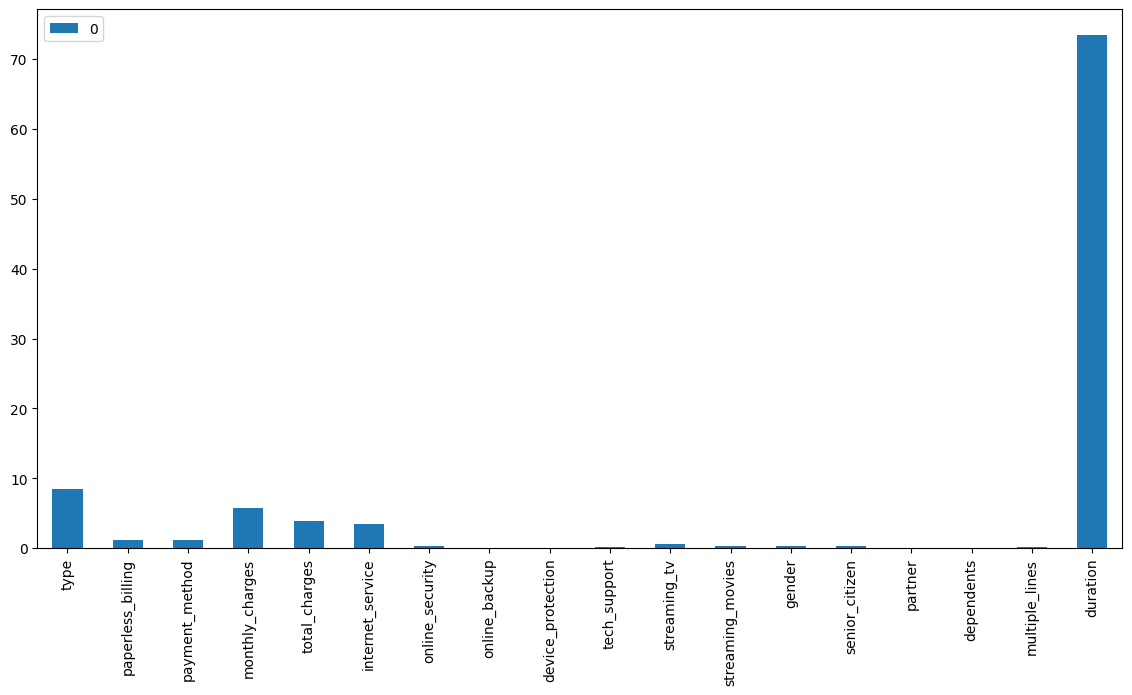

In [89]:
fi = pd.DataFrame(model.feature_importances_, features.columns)
fi.plot(kind='bar', figsize=(14,7));

очень интересно что с настолько большим отрывым в лидеры - маркеры предсказаний выбился стаж в днях

### AUC ROC кривая

auc roc 0.9402976677069922


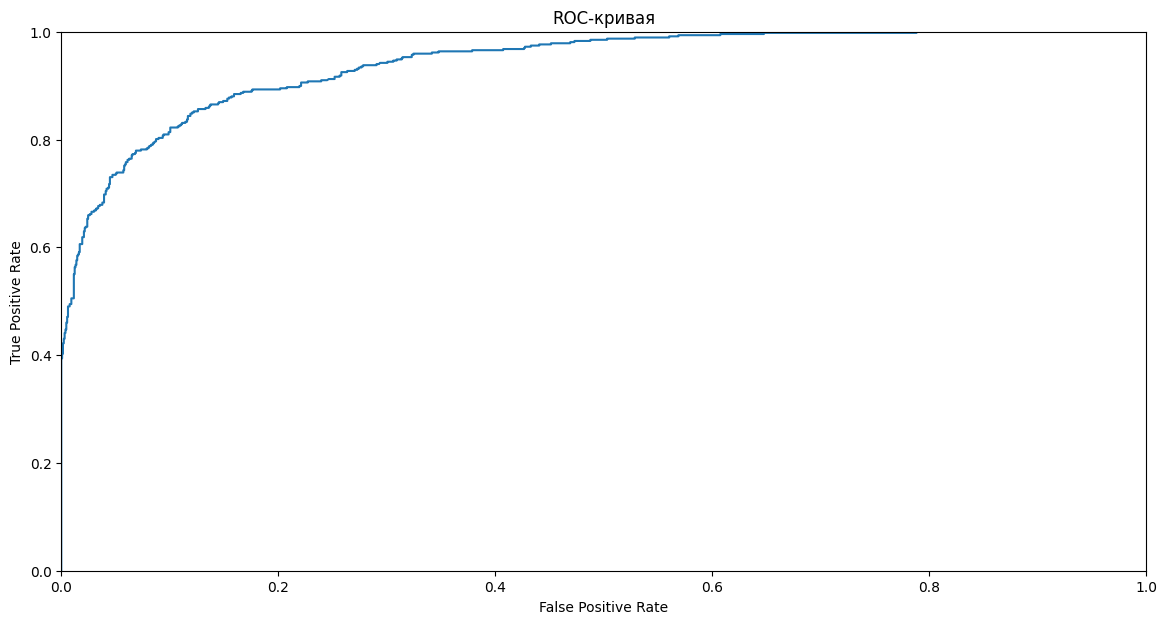

In [90]:
auc_roc = roc_auc_score(y_test, probabilities_one)
print('auc roc',auc_roc)

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one)
figure(figsize=(14, 7))
plt.plot(fpr, tpr, linestyle='solid')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()


### матрица ошибок

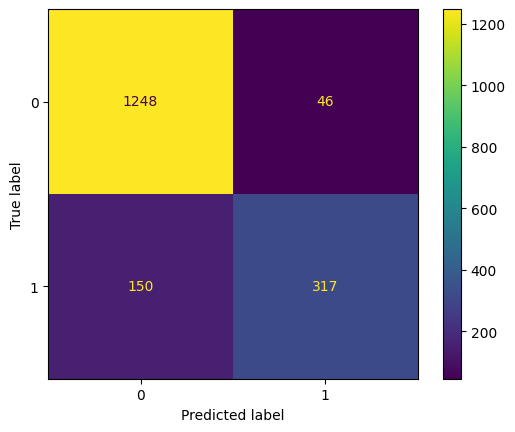

In [91]:
predict = model.predict(x_test)
conf_m = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(conf_m)
disp.plot();

## Выводы

### План

### выполнено

* обьединить таблицы в один датафрейм по айди пользователя
* заполнить пропуски в полученной таблице
* преименовать столбцы в корректный стиль, заменить целевой признак на 1 и 0 
* выделить из столбца с датами столбец "стажа" пользователя (количество дней с момента подключения)
* удалить признаки которые могут привести к утечке данных
* заменить бинарные ответы в столбцах на 0 и 1
* поделить данные на трейн и тест
* скалировать числовые признаки 
* для столбцов с мультиответами использовать OHE
* обучить нескольно моделей используя кросвалидацию. Метрика качества AUC-ROC, бейслайн 0.85
* для перспективных моделей подобрать гиперпараметры
* проверить лучшую модель с настроенными гиперпараметрами на тестовой выборке
* сделать анализ лучшей модели (матрица ошибок, важность признаков)


### не выполено

* сравнить с константной дамми моделью на тесте: 

с учетом интересующей нас метрики качества auc-roc значение дамми модели будет 0.5, что по определению ниже бейслайна 0.85, подобная проверка смысла не добавляет

In [92]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
probabilities_d_test = dummy_clf.predict_proba(x_test)
probabilities_d_one_test = probabilities_d_test[:, 1]
print('roc auc dummy',roc_auc_score(y_test, probabilities_d_one_test))


roc auc dummy 0.5


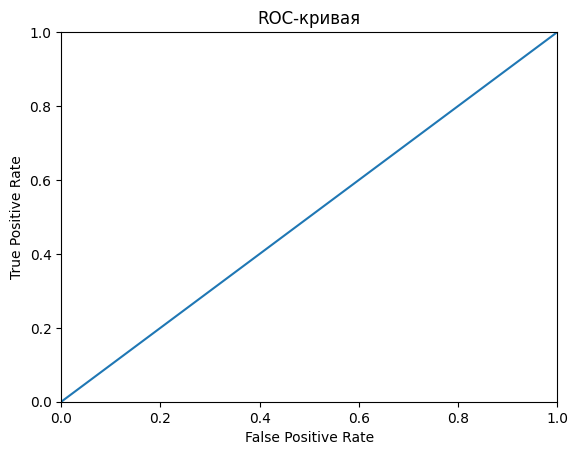

In [93]:
fpr_d, tpr_d, thresholds = roc_curve(y_test, probabilities_d_one_test)
plt.figure()
plt.plot(fpr_d, tpr_d, linestyle='solid')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Трудности и подводные камни; решения

* при обьединении таблиц образовались пропуски так как количество строк в таблицах df_internet df_phone было меньше. Изначально все отсутсвующие значения таблицы df_internet я заполнил нулями - так как отстуствие упоминания об услуге = отсутсвие услуги; не заметив что столбец internet_service который находится в той же неполной таблице обозначает тип подключения. Подобное заполнение в итоге привело к ошибке при использовании OneHotEnc - так как в столбце были и строковые и цифровые данные. Изменил заполнение пропусков конкретно этого категориального столбца на значения 'unknown'

* столбец total_charges был заполнен в строковом формате и при приведении к числовому выдавал ошибку. Как выяснилось это было изза наличия неявных пропусков - новых клиентов зарегистрированных в день создания таблицы. При проверке выяснилось что данные этого столбца введены постфактум оплаты - эти пропуски заполнил нулями и привел ктолбец к типу флоат

* пропуски столбцы multiple_lines нет возможности заполнить реальными данными; проверил как отреагирует метрика при разном из заполнении (чтобы не удалять и не терять другие важные данные из этих строк) и заполнил нулями

* столбец end_date выполнял 2 функции одновременно: показывал дату отключения и проверял наличие факта отключения; в результате чего имел неудобный тип данных для работы; на основе его копии выделил и заполнил целевой признак; а сам столбец - для актуальных клиентов - заполнил датой конца таблицы - чтобы на основении этого выделить новый признак - "стаж" клиента

* обработку категориальных признаков для линейной модели проводил с помощью pd.get_dummies - после фидбека что это не самая удачная практика подготовки данных для МЛ моделей изменил на OHE

* изначально в планах было для градиентных моделей подобобрать первичные границы поиска randomSearch-em, а затем "добить" до наилучших показателей gridSearch-em - в примерно нащупанном "наилучшем" диапазоне - однако как оказалось рандом серч работает настолько быстрее что сделать для него более мелкую сетку поиска и попробовать несколько вариантов шага куда быстрее и эффективнее

## Ключевые шаги в решении задачи

### шаги

* загрузил данные
* рассмотрел каждый из 4 датафреймов 
* проверил корректность дат
* оценил баланс классов целевого признака
* обьединил 4 таблицы в одну по юзер айди
* заполнил появившиеся после обьединения пропуски
* сделал customer_id индексом
* привел столбцы к snake_case
* на основании end_date сформировал столбец целевого признака; привели его к формату 1 \ 0
* для текущих пользователей заполнил end_date датой конца таблицы; перевели в формат даты; сформировал столбец "стажа" пользователя = дельты между началом и концом обслуживания
* удалил end_date и begin_date
* столбцы с бинарной классификацией привел к виду 0 \ 1
* разделил данные на 2 стратифицированные по целевому признаку выборки с соотношением 75 \ 25
* скалировал числовые признаки
* закодировал категориальные признаки с помощью OHE (не пригодилось для итоговой модели)
* обучил нескольно моделей используя кросвалидацию с минимальным тюном чтобы оценить перспективность донастройки (дерево, лес, динейная, кэтбуст, сгд). Метрика качества AUC-ROC, бейслайн 0.85
* затюнил кэт и сгд
* проверили найденные наилучшие настройки модели catboost на тестовой выборке
* для лучшей модели (CatBoostClassifier с параметрами: loss_function="Logloss", eval_metric ='AUC',verbose=50, depth=2, iterations=365, learning_rate=0.36 при random_state = 130323 ) визуализировал важноность признаков; ROC кривую; матрицу ошибок

### ключевые шаги

с учетом важности признаков ключевым шагом можно считать выделение вспомогательного признака - стажа пользователя а так же предобработку данных. После нее все из рассматриваемых моделей показали приемлимый результат, и находились около бейслайна даже при минимальной настройке.

## признаки лучшей модели.Их предобработка

№ | название признака | предобработка
---|---|---
 1  | type                                                  | без предобработки. Подается в списке categorical в model.fit в параметрах (cat_features=categorical)
 2  |  paperless_billing                      | бинарный признак - переведен из формата Yes \ No в формат 1 \ 0
 3  |  payment_method	                      | без предобработки. Подается в списке categorical в model.fit в параметрах (cat_features=categorical)
 4  |  monthly_charges                             | численный признак. Обучен и скалирован на трейне
 5  |  total_charges	                             | численный признак. был в формате object, и имел неявные пропуски в виде ' '; заменены на нули; переведен в числовой формат.Обучен и скалирован на трейне
 6  |  internet_service                              | категориальный признак, имел пропуски заполненные значением 'unknown'. Подается в списке categorical в model.fit в параметрах (cat_features=categorical)
 7  |  online_security                             | бинарный признак - переведен из формата Yes \ No в формат 1 \ 0. Имел пропуски означающие отстуствие услуги - заполненные нулями
 8  |  online_backup                              | бинарный признак - переведен из формата Yes \ No в формат 1 \ 0. Имел пропуски означающие отстуствие услуги - заполненные нулями
 9  |  device_protection                     | бинарный признак - переведен из формата Yes \ No в формат 1 \ 0. Имел пропуски означающие отстуствие услуги - заполненные нулями
 10 |  tech_support                  | бинарный признак - переведен из формата Yes \ No в формат 1 \ 0. Имел пропуски означающие отстуствие услуги - заполненные нулями
 11 | streaming_tv                    | бинарный признак - переведен из формата Yes \ No в формат 1 \ 0. Имел пропуски означающие отстуствие услуги - заполненные нулями
 12 | streaming_movies                     | бинарный признак - переведен из формата Yes \ No в формат 1 \ 0. Имел пропуски означающие отстуствие услуги - заполненные нулями
 13 | gender             | бинарный признак - переведен из формата Male \ Female в формат 1 \ 0.
 14 | senior_citizen              | без предобработки
 15 | partner             | бинарный признак - переведен из формата Yes \ No в формат 1 \ 0.
 16 | dependents              | бинарный признак - переведен из формата Yes \ No в формат 1 \ 0.
 17 | multiple_lines                     | бинарный признак - переведен из формата Yes \ No в формат 1 \ 0. Имел пропуски которые после проверки заполнены нулями. Приведено в числовой формат
 18 | duration                     | "стаж клиента". требовал несколько этапов; begin_date: приведен в формат даты. end_date: no - заменены на дату конца таблицы, приведен в формат даты. Расчитана дельта между датой end_date и begin_date. Переведена в формат int. Обучена и скалирована на трейне

целевой признак target выделен из копии столбца end_date где начличие даты заменено на 1 и переведено в числовой формат. (1 - соответствует тому что клиент ушел; 0 - не ушел.) Бинарный целевой признак


In [94]:
x_train.head(1)

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,duration
customer_id,,,,,,,,,,,,,,,,,,
4782-OSFXZ,Two year,1,Bank transfer (automatic),0.588527,1.551717,DSL,1,1,1,1,0,1,0,1,1,0,1,1.565792


In [95]:
y_train.head(1)

customer_id
4782-OSFXZ    0
Name: target, dtype: int32

## итоговая модель

* лучшие показатели у модели CatBoostClassifier с параметрами: loss_function="Logloss", eval_metric ='AUC',verbose=50, depth=2, iterations=365, learning_rate=0.36 при random_state = 130323
* На тестовой выборке интересующая нас метрика auc-roc составила 0.940
